In [1]:
import math
import random
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def f(x):
    return 3*x**2 - 4*x +5

In [13]:
f(3.0)

20.0

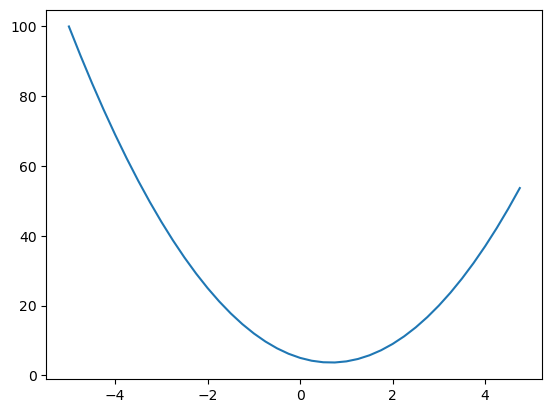

In [14]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [15]:
h = 0.000001
x = 2/3
(f(x + h)-f(x))/h # this is slop

2.999378523327323e-06

In [16]:
# complex
a= 2.0
b= -3.0
c= 10.0
d=a*b + c
print(d)

4.0


In [17]:
h = 0.0001

# input
a= 2.0
b= -3.0
c= 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print("d1",d1)
print("d2",d2)
print("slop",(d2-d1)/h)

d1 4.0
d2 3.999699999999999
slop -3.000000000010772


In [18]:
h = 0.0001

# input
a= 2.0
b= -3.0
c= 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print("d1",d1)
print("d2",d2)
print("slop",(d2-d1)/h)

d1 4.0
d2 4.0001
slop 0.9999999999976694


In [2]:
class Value:
    def __init__(self,data , _children=(), _op ='',label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op =  _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
        
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 *out.grad
        out._backward = _backward
        
        return out

    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self,other),'*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self,other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other,(self,),f'**{other}')

        def _backward():
            self.grad += other * self.data**(other-1)* out.grad
        out._backward = _backward
        
        return out

    def __rmul__(self,other):
        return  self*other

    def __truediv__(self,other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        n= self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t , (self,),'tanh')

        def _backward():
            self.grad += (1- t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,),'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):            
            topo = []
            visited = set()
            def build_topo(v):
                if v not in visited:
                    visited.add(v)
                    for  child in v._prev:
                        build_topo(child)
                    topo.append(v)
            build_topo(self)
        
            self.grad = 1.0
            for node in reversed(topo):
                node._backward()

    


In [14]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [3]:
from graphviz import Digraph

def trace(root):
    nodes,edges=set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format='svg' ,graph_attr={'rankdir': 'LR'})

    nodes, edges= trace(root)
    for n in nodes:
        uid =str(id(n))
        dot.node(name=uid,label="{ %s |data %.4f | grad %.4f }"% (n.label, n.data, n.grad ),shape='record')
        if n._op:
            dot.node(name=uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)


    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2)) + n2._op)
    return dot


In [62]:
def lol():
    h = 0.0001
    
    a = Value(2.0 , label='a')
    b = Value(-3.0 , label='b')
    c = Value(10.0 , label='c')
    e = a*b;e.label='e'
    d = e + c;d.label='d'
    f = Value(-2.0, label='f')
    L = d* f ; L.label='L'
    L1 = L.data

    a = Value(2.0  , label='a')
    b = Value(-3.0  , label='b')
    c = Value(10.0 , label='c')
    e = a*b;e.label='e'
    
    d = e + c;d.label='d'
    f = Value(-2.0 , label='f')
    L = d* f ; L.label='L'
    L2= L.data 

    print((L2-L1)/h)
lol()

0.0


In [63]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

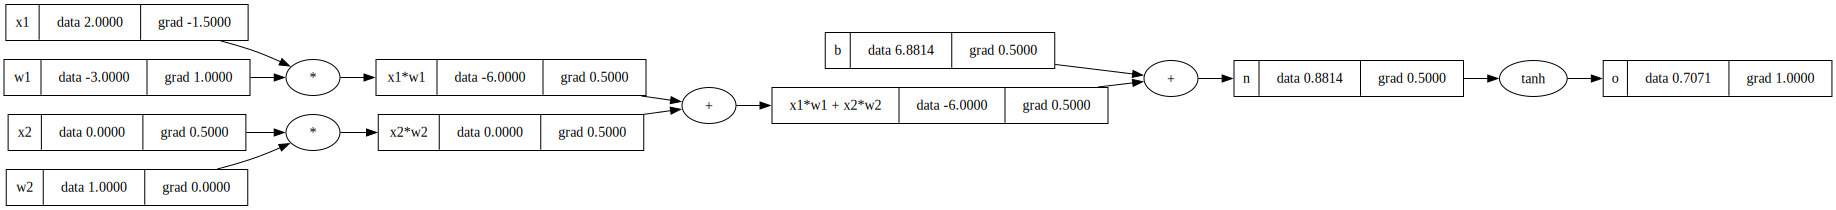

In [64]:
draw_dot(o)

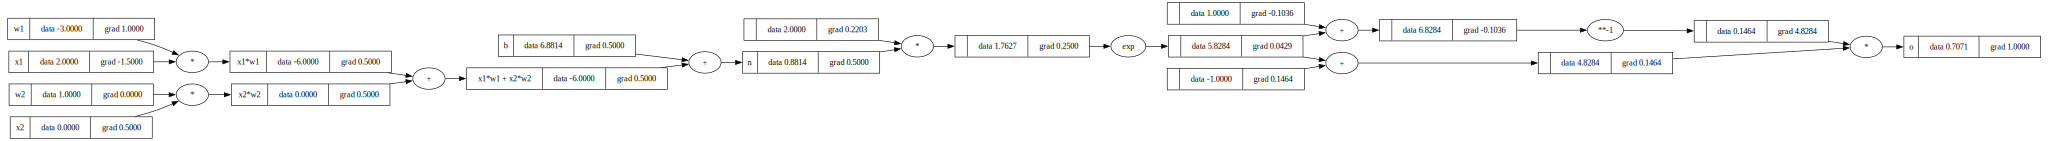

In [65]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#----
e = (2*n).exp()
o = (e-1) / (e + 1)
#----
o.label = 'o'
o.backward()
draw_dot(o)

In [4]:
import torch

In [5]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
out of bounds for dimen
print(o.data.item()) # can directky use .item instead of .data.item
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [75]:
class Neuron:

    def __init__(self, nin):
     self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
     self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
        # params = []
        # for neuron.parameters in self.neurons:
        #   ps =  neurons,parameters()
        #   parmas.extend(ps)
        # return x

            
class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
     return [p for layer in self.layers for p in layer.parameters()]

In [76]:
x = [2.0,3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.6147397863749967)

In [77]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired output


In [71]:
ypred = [n(x) for x in xs]
loss = sum(((yout - ygt)**2 for ygt ,yout in zip(ys,ypred)),Value(0.0))
loss

Value(data=7.999999999881268)

In [94]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)),Value(0.0))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 0.0017652615009029018
1 0.0017533731676153195
2 0.0017416392019502023
3 0.001730056650510764
4 0.0017186226343091093
5 0.0017073343464464835
6 0.0016961890498793898
7 0.0016851840752681018
8 0.0016743168189040504
9 0.001663584740712585
10 0.0016529853623281307
11 0.0016425162652386068
12 0.001632175088996133
13 0.0016219595294915052
14 0.001611867337289575
15 0.0016018963160232408
16 0.0015920443208434832
17 0.0015823092569233741
18 0.0015726890780136513
19 0.0015631817850480483


In [95]:
ypred

[Value(data=0.9814755261001105),
 Value(data=-0.989429655596601),
 Value(data=-0.9754365642850193),
 Value(data=0.9775293280730214)]